# import

In [1]:
import sys
sys.path.append('../')
from my_library.library import *
from hyperopt import hp, tpe, Trials, fmin,STATUS_OK
from my_library.funcs import *
from scipy import fftpack
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Meiryo'


# path win

In [2]:
path_tpx = '/Users/Owner/Desktop/StockPriceData/Stock_index/TOPIX_10years.csv'
path_225 = '/Users/Owner/Desktop/StockPriceData/Stock_index/NK225_10years.csv'
path_daw = '/Users/Owner/Desktop/StockPriceData/Stock_index/DAW_10years.csv'
path_bear = '/Users/Owner/Desktop/StockPriceData/Stock_index/R225BEAR_10years.csv'
path_tpx_sim = '/Users/Owner/Desktop/StockPriceData/TOPIX/TOPIX_20211208.csv'
path_daw_sim = '/Users/Owner/Desktop/StockPriceData/DAW/DAW_20211208.csv'
load_pickle_path = '/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles'
save_pickle_path = '/Users/Owner/Desktop/program/Sotsuron/code/pickles'

# funcs

In [256]:

def return_corr(df):
    x = df['daw_close'].values
    y = df['close'].values
    corr = np.corrcoef(x,y)
    return corr

def split_df(df,start_year,end_year,start_month=1,end_month=12):
    df = df[df.index.year<=end_year]
    df = df[df.index.year>=start_year]
    df = df[df.index.month<=end_month]
    if start_month>0:
        df = df[df.index.month>=start_month]
    return df

def make_value_list(lx,start_year,end_year,path_tpx,path_daw,alpha=0.34,width=20,stride=10,start_month=1,end_month=12):

    lc_dummy = LearnClustering(width=width)
    df_con = lc_dummy.make_df_con(path_tpx,path_daw)
    
    df_con = split_df(df_con,start_year,end_year,start_month,end_month)
    
    x_,z_ = lc_dummy.make_x_data(df_con['close'],stride=stride,test_rate=1.0,width=width)
    length = len(z_)
    value_list = []

    for i in range(length):
        for strategy in ['normal','reverse']:
            try:
                xl = XGBSimulation2(lx,alpha=alpha)
                xl.simulate(path_tpx,path_daw,strategy=strategy,is_validate=True,start_year=start_year,end_year=end_year,df_=z_[i])
                
                trade_log =  xl.trade_log
                total_profit = trade_log['total_profit'].values[0]
                stock_wave = z_[i]
                vt = ValueTable(strategy,alpha,total_profit,trade_log,stock_wave)
                value_list.append(vt)
                
            except Exception as e:
                print(e)
                continue

    return value_list

def make_value_lx_dict(width=20,stride=5,path_=path_tpx):
    lx_dict = {}
    value_dict = {}


    lx_dummy = LearnXGB(num_class=3)
    x_train,y_train,_,_= lx_dummy.make_xgb_data(path_,path_daw,test_rate=1.0)
    _,_ ,x_test,y_test = lx_dummy.make_xgb_data(path_,path_daw,test_rate=0.9)

    limit_year = 2011
    x_train_ = split_df(x_train,2011,limit_year)
    y_train_ = y_train[:len(x_train_)]
    lx = LearnXGB(num_class=3)
    lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)
    lx_dict[str(limit_year)] = lx

    for year in range(limit_year,2022):
        start_year = 2011
        end_year = year

        x_train_ = split_df(x_train,start_year,end_year)
        y_train_ = y_train[:len(x_train_)]
        
        
        lx = LearnXGB(num_class=3)
        lx.learn_xgb2(x_train_,y_train_,x_test,y_test,verbose=False)

        last_key = next(reversed(lx_dict),None)
        value_list = make_value_list(lx_dict[last_key],year,year,path_,path_daw,width=width,stride=stride)
        value_dict[str(year)] = value_list
        
        lx_dict[str(year)] = lx
    
    return value_dict,lx_dict
        
def return_clx(Value_list):
    Value_good = sorted(Value_list,key=lambda x :x[2],reverse=True)
    Value_bad = sorted(Value_list,key=lambda x :x[2],reverse=False)
    ng = []
    rg = []
    nb = []
    rb = []
    
    # 1sigam = 外れ値 として処理する
    prf_list=[]
    for vg in Value_good:
        total_profit = vg.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for idx,v in enumerate(Value_good):
        if v.total_profit<=0:break
        # if np.abs(st_prf[idx]) >=1:continue    

        df = v.stock_wave
        strategy = v.strategy
        # print(df)
        # break
        if strategy=="normal":
            ng.append(standarize(df))
        else:
            rg.append(standarize(df))

    prf_list=[]
    for vb in Value_bad:
        total_profit = vb.total_profit
        prf_list.append(total_profit)      
    prf_array = np.array(prf_list)
    st_prf = standarize(prf_array)

    for v in Value_bad:
        if v.total_profit>=0 :break
        # if np.abs(st_prf[idx]) >=1:continue  
        
        df = v.stock_wave
        strategy = v.strategy

        if strategy=="normal":
            nb.append(standarize(df))
        else:
            rb.append(standarize(df))

    x_ng = make_easy_x(ng)
    x_nb = make_easy_x(nb)
    x_rg = make_easy_x(rg)
    x_rb = make_easy_x(rb)
    return x_ng,x_nb,x_rg,x_rb

def concat_list(key_list,value_dict):
    value_list = []
    for key in key_list:
        v_lis = value_dict[key]
        for v in v_lis:
            value_list.append(v)
    return value_list

def return_uds_dict(value_dict,lx_dict,width=20,stride=5\
    ,cut_off=6,order=4,path_=path_tpx,limit_year=2012):
    uds_dict = {}
    trade_dict = {}
    lx_dummy = LearnXGB(num_class=3)
    alpha = 0.34

    for year in range(limit_year,2022):
        # print(year)
        start_month=1
        end_month = 12
        start_year = year
        end_year = year
        value_list = value_dict[str(year-1)]
        lx_ = lx_dict[str(year-1)]
        x_ng,x_nb,x_rg,x_rb = return_clx(value_list)

        try:
            Ustrategies= return_uds(lx_,x_ng,x_nb,x_rg,x_rb,UpDownSimulation,width=width,stride=stride,\
                cut_off=cut_off,order=order)
            """
            # Fstrategies をどんどん加算していく    
            # if len(uds_dict)>0:
            #     last_key = next(reversed(uds_dict),None)
            #     Fstrategies_old = uds_dict[last_key].Ustrategies
            #     Fstrategies = return_cumulative_fst(Fstrategies,Fstrategies_old)
            """
        except Exception as e:
            print(e)
            last_key = next(reversed(uds_dict),None)
            Ustrategies = uds_dict[last_key].Ustrategies
        
        uds = UpDownSimulation(lx_,Ustrategies,width=width,alpha=alpha)
        uds.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True,cut_off=cut_off,order=order)
        
        uds_dict[str(year)] = uds
        trade_dict[str(year)] = (uds.trade_log,uds.pr_log,uds.accuracy_df,uds.cnt_normal,uds.cnt_reverse)
    
    return uds_dict, trade_dict

def return_uds(lx,x_ng,x_nb,x_rg,x_rb,UpDownSimulation,width=20,stride=10,cut_off=6,order=4):

    log_dict = {}
    cs_dict = {}
    ffs_dict = {}
    random_state=0
    alpha = 0.33
    n_cluster = 1
    Ustrategies = []

    lc_rg = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rg.learn_clustering3(x_rg,width=width)
    lc_rb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_rb.learn_clustering3(x_rb,width=width)
    lc_ng = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_ng.learn_clustering3(x_ng,width=width)
    lc_nb = LearnClustering(n_cluster=n_cluster,random_state=random_state)
    lc_nb.learn_clustering3(x_nb,width=width)

    strategy_list = ['normal','stay','reverse','stay']

    j=0
    for lc in [lc_ng,lc_nb,lc_rg,lc_rb]:
        
        for _,key in enumerate(lc.wave_dict):
            wave = lc.wave_dict[key]
            # このタイミングでハイパスフィルタかける
            # make_spectrum 内の関数をいじる
            filtered_wave = butter_lowpass_filter(wave,cut_off,len(wave),order=order)
            strategy = strategy_list[j]
            us  = Fstrategy(strategy,alpha,filtered_wave)
            Ustrategies.append(us)

        j+=1

    return Ustrategies

def plot_profit(trade_dict,verbose=False):
    total_profit = 0
    mean_profit = 0
    mean_profit_rate = 0
    total_profit_rate = 0
    for idx,key in enumerate(trade_dict):
        print(key)
        print(trade_dict[key])
        td = trade_dict[key]
        total_profit += td['total_profit'].values[0]
        total_profit_rate += td['profit rate'].values[0]
        
    mean_profit = total_profit/(idx+1)
    mean_profit_rate = (total_profit_rate)/(idx+1)

    print('total profit :{0}'.format(total_profit))
    print('mean profit :{0}'.format(mean_profit))
    print('total profit rate :{0}'.format(total_profit_rate))
    print('mean profit rate : {0}'.format(mean_profit_rate))
    if verbose:
        return total_profit,mean_profit,total_profit_rate,mean_profit_rate
    else:
        return 0
    
def plot_var(pr_list_ts,pr_list,key):
    height1 = pr_list_ts.copy()
    height2 = pr_list.copy()


    left = np.arange(len(height1))  # numpyで横軸を設定
    labels = [str(year) for year in range(2017,2022)]
    # labels.append('Total')


    width = 0.4
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    ax.bar(left, height1, color='darkgray', width=width, align='center',label='Golden and Dead')
    ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='Proposed method')

    plt.xticks(left + width/2, labels)
    ax.set_xlabel(key)
    ax.set_ylabel("Rate of return (%)")
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    # ax.set_xticks(labels)

    plt.show()
    
def plot_cumulative_var(cumulative_pr_list_ts,cumulative_pr_list,key):
    height1 = cumulative_pr_list_ts.copy()
    height2 = cumulative_pr_list.copy()


    left = np.arange(len(height1))  # numpyで横軸を設定
    labels = [str(year) for year in range(2012,2022)]
    # labels.append('Total')


    width = 0.4
    plt.clf()
    fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")
    ax.bar(left, height1, color='darkgray', width=width, align='center',label='GD法')
    ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='提案手法')

    plt.xticks(left + width/2, labels)
    ax.set_xlabel(key)
    ax.set_ylabel("収益率総和 (%)")
    ax.legend(bbox_to_anchor=(0.5, -0.2), loc='center',fontsize=15)
    # ax.set_xticks(labels)

    plt.show()
    
def get_gyosyu_df(path_gyosyu = '/Users/Owner/Desktop/StockPriceData/Gyosyu/'):
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace(path_gyosyu,'')[:-4]
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                        df.columns[9]:'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df_dict[name] = df

    return df_dict,FILE


# class

In [4]:


class UpDownSimulation(Simulation):
    
    
    def __init__(self,lx,Ustrategies,width=20,alpha=0.34):
        super(UpDownSimulation,self).__init__()
        self.lx = lx 
        self.xgb_model = lx.model
        self.Ustrategies = Ustrategies
        self.width = width
        self.alpha = alpha
        self.ma_long = 25
        self.ma_short = 5
    
    
    def choose_strategy(self,wave,cut_off=6,order=4):
        filtered_wave = butter_lowpass_filter(wave,cut_off,len(wave),order=order)
        diff_wave = np.diff(filtered_wave)
        sum_diff = sum(diff_wave)
        strategy = 'none'

        # 右肩下がりの時
        if sum_diff<=0:
            strategy = 'stay'
    
        # 右肩上がりの時
        else:
            normal_wave = self.Ustrategies[0].spectrum
            reverse_wave = self.Ustrategies[2].spectrum
            
            n_cos = cos_sim(normal_wave,wave)
            r_cos = cos_sim(reverse_wave,wave)
            if n_cos>=r_cos:
                strategy = 'normal'
            else:
                strategy = 'reverse'
                
        return strategy
    
    def make_x_dict(self,path_tpx,path_daw):
        df_con = self.make_df_con(path_tpx,path_daw)
        x_dict = {}
        lc = LearnClustering()
        x_, z_ = lc.make_x_data(df_con['close'],stride=1,test_rate=1.0,width=self.width)
        length = len(z_)

        for i in range(length):
            time_ = z_[i].index[-1]
            x_dict[time_] = standarize(x_[i])
        
        return x_dict
    

    def simulate(self, path_tpx, path_daw, is_validate=False,is_online=False,start_year=2021,end_year=2021,start_month=1,end_month=12,
        is_observed=False,cut_off=6,order=4,HOLD_DAY=20):

        x_check,y_check,y_,df_con,pl = self.simulate_routine(path_tpx, path_daw,start_year,end_year,start_month,end_month,'None',is_validate)
        self.x_check = x_check
        x_tmp,y_tmp,current_date,acc_df = self.set_for_online(x_check,y_)
        x_dict = self.make_x_dict(path_tpx,path_daw)
        length = len(x_check)
        prf_list = []
        predict_proba = self.xgb_model.predict_proba(x_check.astype(float))
        self.predict_proba = predict_proba
        is_bought = False
        index_buy = 0
        index_sell = 0
        prf = 0
        hold_day = 0
        trigger_count = 0
        trade_count = 0
        total_eval_price = 0
        cant_buy = 0
        buy_count = 0
        sell_count = 0
        # for debug
        self.strategies = []
        self.spe_list = []
        self.cnt_normal = 0
        self.cnt_reverse = 0
        pre_trategy = 'none'
        self.stay_detect_count = 0
        
        for i in range(length-1):
            is_trigger = False
            time_ = df_con.index[i]
            wave = x_dict[time_]

            if not is_bought:
                strategy = self.choose_strategy(wave,cut_off=cut_off,order=order)
                pre_strategy = strategy

            # 差分
            # if is_bought:
            #     strategy = self.choose_strategy(wave,cut_off=cut_off,order=order)
            #     if pre_strategy!='none' and (pre_strategy=='normal' or pre_strategy=='reverse') and strategy=='stay':
            #         is_trigger=True
            #         self.stay_detect_count += 1
                
            row = predict_proba[i]
            label = np.argmax(row)
            prob = row[label]
            total_eval_price = prf
            self.pr_log['reward'].loc[df_con.index[i]] = prf 
            self.pr_log['eval_reward'].loc[df_con.index[i]] = total_eval_price
            tmp_date = x_tmp.index[i]   

            if is_online and current_date.month!=tmp_date.month:
                predict_proba, current_date = self.learn_online(x_tmp,y_tmp,x_check,current_date,tmp_date)


            if prob > self.alpha:
                if label == 0:
                    acc_df.iloc[i] = 0
                elif label == 1:  
                    acc_df.iloc[i] = 1
                else: #  label==2
                    acc_df.iloc[i] = 2

            if strategy=='reverse':
                self.strategies.append(-1)
                is_buy  = (label==0 and prob>self.alpha)
                is_sell = (label==2 and prob>self.alpha)
                is_cant_buy = (is_observed and (df_con['open'].loc[x_check.index[i+1]] > df_con['close'].loc[x_check.index[i]]))
                if is_buy and is_bought: self.cnt_reverse += 1
            
            elif strategy=='normal':
                self.strategies.append(1)
                is_buy  = (label==2 and prob>self.alpha)
                is_sell = (label==0 and prob>self.alpha)
                is_cant_buy = (is_observed and (df_con['open'].loc[x_check.index[i+1]] < df_con['close'].loc[x_check.index[i]]))
                if is_buy and is_bought: self.cnt_normal += 1
            
            elif strategy=='stay' :
            
                self.strategies.append(0)
                is_buy = False
                is_sell =  False
                is_cant_buy = False

            
            if not is_bought:
                
                if is_cant_buy:
                    cant_buy += 1
                    continue
                elif is_buy:
                    index_buy, start_time, is_bought = self.buy(df_con,x_check,i)
                    buy_count += 1

            else:
                hold_day += 1
                
                if hold_day>=HOLD_DAY:
                    trigger_count+=1
                    is_trigger = True
                
                if is_sell or is_trigger:
                    prf, trade_count, is_bought = self.sell(df_con,x_check,prf,index_buy,prf_list,trade_count,pl,start_time,i,is_validate)
                    hold_day = 0
                    is_trigger = False
                    sell_count += 1
                else:
                    total_eval_price = self.hold(df_con,index_buy,total_eval_price,i)
                    
            
            self.is_bought = is_bought
                
        
        if is_bought:
            index_sell = df_con['close'].loc[x_check.index[-1]] 
            prf += index_sell - index_buy
            prf_list.append(index_sell - index_buy)
            end_time = x_check.index[-1]
            trade_count+=1
            if not is_validate:
                pl.add_span(start_time,end_time)

        
        self.pr_log['reward'].loc[df_con.index[-1]] = prf 
        self.pr_log['eval_reward'].loc[df_con.index[-1]] = total_eval_price
        prf_array = np.array(prf_list)
        self.acc_df = acc_df
        self.y_check = y_check
            
        
        # try:
        df = self.calc_acc(acc_df, y_check)
        self.accuracy_df = df
        log = self.return_trade_log(prf,trade_count,prf_array,cant_buy)
        self.trade_log = log
        
        
        if not is_validate:
            print(log)
            print("")
            print(df)
            print("")
            print("trigger_count :",trigger_count)
            # print("buy_count",buy_count)
            # print("sell_count",sell_count)
            pl.show()
            


# メモ

1. 業種の寄与率などキチンと考慮すべき
2. ログをちゃんととる

# load pickle

In [20]:
value_dict = load_pickle(save_pickle_path+'/value_dict_w20.pickle')
lx_dict = load_pickle(save_pickle_path+'/lx_dict_w2.pickle')

# make uds object

In [21]:
uds_dict,trade_dict = return_uds_dict(value_dict,lx_dict,width=20,stride=5\
    ,cut_off=6,order=4,path_=path_tpx,limit_year=2012)

# save pickle

In [293]:

# save_pickle(save_pickle_path+'/uds_dict.pickle',uds_dict)
# save_pickle(save_pickle_path+'/trade_dict.pickle',trade_dict)
# save_pickle(save_pickle_path+'/accuracy_dict.pickle',accuracy_dict)
# save_pickle(save_pickle_path+'/accuracy_gyosyu_dict.pickle',accuracy_gyosyu_dict)

In [85]:
uds_dict_copy = load_pickle(save_pickle_path+'/uds_dict.pickle')

# XGB 予測精度

In [254]:
accuracy_dict = {}

for i,key in enumerate(uds_dict):
    year = int(key)
    uds = uds_dict[key]
    lx = uds.lx 
    xl = XGBSimulation2(lx)
    xl.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True)
    accuracy_dict[key] = xl.accuracy_df

In [276]:
accuracy_gyosyu_dict = {}
# name_ = 'DENKIKIKI'

for i,name_ in enumerate(uds_gyosyu_dict):
    uds_dict_ = uds_gyosyu_dict[name_]
    accuracy_dict_ = {}

    for i,key in enumerate(uds_dict_):
        year = int(key)
        uds = uds_dict_[key]
        lx = uds.lx 
        xl = XGBSimulation2(lx)
        xl.simulate(path_tpx,path_daw,start_year=year,end_year=year,is_validate=True)
        accuracy_dict_[key] = xl.accuracy_df

    accuracy_gyosyu_dict[name_] = accuracy_dict_

division by zero


In [282]:
ts = TPXSimulation()
df_con = ts.make_df_con(path_tpx,path_daw)
mk = MakeTrainData3(df_con,test_rate=1.0)
x_valid,y_,_,_ = mk.make_data()
y_valid = pd.DataFrame(y_)
y_valid.index = x_valid.index

x_test = split_df(x_valid,2021,2021)
y_test = split_df(y_valid,2021,2021)
xgb_model = uds_gyosyu_dict['KOUGYO']['2021'].lx.model

hr_pred = xgb_model.predict(x_test.astype(float))
print(classification_report(np.array(y_test), hr_pred))

              precision    recall  f1-score   support

           0       0.32      0.92      0.48        77
           1       0.00      0.00      0.00        90
           2       0.41      0.12      0.19        75

    accuracy                           0.33       242
   macro avg       0.24      0.35      0.22       242
weighted avg       0.23      0.33      0.21       242



C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\metrics\_classification.py:1308: Unde

In [290]:
for i,name_ in enumerate(accuracy_gyosyu_dict):
    try:
        accuracy_dict_ = accuracy_gyosyu_dict[name_]
        out_put = ''
        acc_list = []
        for i,key in enumerate(accuracy_dict_):
            accuracy_df = accuracy_dict_[key]
            
            accuracy_ = accuracy_df['score'].values[0]
            accuracy_ = round(accuracy_,2)
            acc_list.append(accuracy_)
            out_put += '+ {:.2f}'.format(accuracy_)
            
        mean_acc = np.mean(acc_list)
        out_put += '& {:.2f}'.format(mean_acc)
        out_put += '\\\\'
        print(name_,' ',out_put)    
        print("---------------------")
    except Exception as e:
        print(e)
        print(name_)
        

DENKIKIKI   & 0.35& 0.43& 0.49& 0.48& 0.46& 0.44\\
---------------------
DENKI_GASS   & 0.27& 0.38& 0.31& 0.38& 0.39& 0.35\\
---------------------
GARAS_DOSEKI   & 0.30& 0.38& 0.46& 0.41& 0.45& 0.40\\
---------------------
GINKOU   & 0.30& 0.38& 0.40& 0.39& 0.44& 0.38\\
---------------------
GOMU   & 0.25& 0.36& 0.45& 0.39& 0.41& 0.37\\
---------------------
HIKINZOKU   & 0.35& 0.43& 0.41& 0.41& 0.42& 0.40\\
---------------------
HOKEN   & 0.25& 0.42& 0.45& 0.42& 0.40& 0.39\\
---------------------
HUDOUSAN   & 0.52& 0.43& 0.49& 0.45& 0.43& 0.46\\
---------------------
IYAKUHIN   & 0.37& 0.39& 0.47& 0.44& 0.45& 0.42\\
---------------------
JOUHOU_TSUUSIN   & 0.28& 0.43& 0.50& 0.41& 0.47& 0.42\\
---------------------
KAGAKU   & 0.41& 0.44& 0.40& 0.46& 0.47& 0.44\\
---------------------
KAIUN   & 0.24& 0.40& 0.35& 0.38& 0.44& 0.36\\
---------------------
KENSETSU   & 0.36& 0.50& 0.45& 0.44& 0.45& 0.44\\
---------------------
KIKAI   & 0.30& 0.41& 0.41& 0.46& 0.44& 0.40\\
-----------------

# ave wave

In [46]:
ave_wave = np.zeros(20)
ave_wave_dict = {}  

st = 0

for st in [0,1,2,3]:

    ave_wave = np.zeros(20)
    for idx,key in enumerate(uds_dict_copy):
        # if key=='2017':break
        uds = uds_dict_copy[key]
        wave = uds.Ustrategies[st].spectrum
        ave_wave += wave
        # break
    ave_wave_dict[st] = standarize(ave_wave)


0
1
2
3


<Figure size 432x288 with 0 Axes>

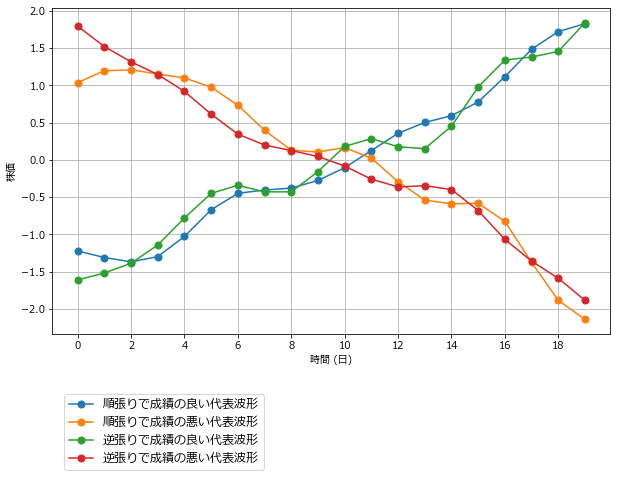

In [82]:
plt.clf()
fig, ax = plt.subplots(figsize=(10, 6), facecolor="w")

for i,key in enumerate(ave_wave_dict):
    wave = ave_wave_dict[key]
    if key==0:
        label = '順張りで成績の良い代表波形'
        # print(key)
        # wave_low_pass = butter_lowpass_filter(wave,6,20)
        ax.plot(wave,label=label,marker='o',markersize=7)
    elif key==1:
        label = '順張りで成績の悪い代表波形'
        ax.plot(wave,label=label,marker='o',markersize=7)
    elif key==2:
        label = '逆張りで成績の良い代表波形'
        ax.plot(wave,label=label,marker='o',markersize=7)
    elif key==3:
        label = '逆張りで成績の悪い代表波形'
        ax.plot(wave,label=label,marker='o',markersize=7)
        
    # print(key)
    # wave_low_pass = butter_lowpass_filter(wave,6,20)
    # ax.plot(wave_low_pass,label=label,marker='o',markersize=7)
    print(key)
        
ax.set_xlabel("時間 (日)")
ax.set_ylabel("株価")
ax.set_xticks(range(0,20,2))
ax.legend(bbox_to_anchor=(0.2, -0.3), loc='center',fontsize=12)
# ax.legend()
ax.grid()
plt.show()

In [90]:
uds_dict_old = load_pickle('/Users/Owner/Desktop/program/Sotsuron/code/wave_pickles/uds_dict.pickle')

# 微分で比べる

In [99]:
spe_d0 = np.diff(ave_wave_dict[0])
spe_d2 = np.diff(ave_wave_dict[2])

In [86]:
pr_list = []
for i,key in enumerate(uds_dict_copy):
    pr_list.append(uds_dict_copy[key].trade_log['profit rate'].values[0])

In [87]:
pr_list

[4.36, 9.48, 2.68, 9.76, 8.28, 2.56, -9.24, 2.6, 7.68, 5.800000000000001]

<Figure size 432x288 with 0 Axes>

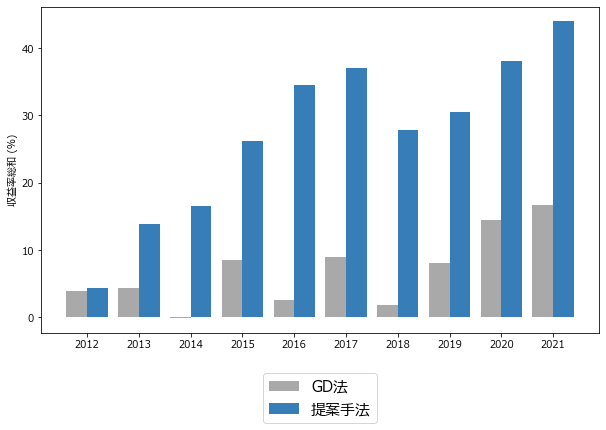

In [104]:

pr_list_ts = [4.00 , 0.36 , -4.44 , 8.68 , -6.04  , 6.36 , -7.04 , 6.20 , 6.40 , 2.26]

cumulative_list = []
for i in range(len(pr_list)):
    total_pr = sum(pr_list[:i+1])
    cumulative_list.append(total_pr)
    
cumulative_list_ts = []
for i in range(len(pr_list_ts)):
    total_pr = sum(pr_list_ts[:i+1])
    cumulative_list_ts.append(total_pr)
    
    
plot_cumulative_var(cumulative_list_ts,cumulative_list,'')

# 業種別 sim

In [181]:
df_dict, FILE = get_gyosyu_df()

In [186]:
uds_gyosyu_dict = {}
trade_gyosyu_dict = {}
for file in FILE:
    name_ = file[43:].replace('.csv','')
    # if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU': 
    
    v_dic, lx_dic = make_value_lx_dict(path_=file)
    uds_dict_, trade_dict_= return_uds_dict(v_dic,lx_dic,width=20,stride=5,\
        cut_off=6,order=4,path_=file,limit_year=2017)
    uds_gyosyu_dict[name_] = uds_dict_
    trade_gyosyu_dict[name_] = trade_dict_

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by ze

C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, 

division by zero
division by zero


In [194]:
# save_pickle(save_pickle_path+'/uds_gyosyu_dict.pickle',uds_gyosyu_dict)
# save_pickle(save_pickle_path+'/trade_gyosyu_dict.pickle',trade_gyosyu_dict)

# 収益率の標準化問題

In [106]:
# uds_gyosyu_dict_copy = load_pickle(save_pickle_path+'/uds_gyosyu_dict.pickle')

ex_tpx_dict

In [209]:
ts = TPXSimulation()
df = ts.make_df_con(path_tpx,path_daw)
ex_tpx_dict = {}

for year in [2016,2017,2018,2019,2020,2021]:
    df_tmp = df[df.index.year==year]
    mean_close = df_tmp.mean()['close']
    # 不偏分散のほうがいい？
    std_close = df_tmp.std()['close']
    ex_tpx_dict[year] = (mean_close,std_close)

technical 業種別収益率

------------------
DENKIKIKI
13.92 & -24.64 & 16.93 & 37.76 & 6.30 & 20.24 & 28.93 \\
------------------
DENKI_GASS
-0.29 & 0.42 & -2.86 & -1.30 & -2.08 & 1.18 & -4.78 \\
------------------
GARAS_DOSEKI
11.76 & -4.59 & 4.62 & 5.15 & 0.58 & 5.40 & 14.27 \\


c:\Users\Owner\Desktop\program\Sotsuron\code\model\New_XGB\..\my_library\library.py:58: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  self.fig, self.ax = plt.subplots(figsize=(10, 6))


------------------
GINKOU
0.21 & -0.90 & -0.41 & -0.02 & 0.83 & 0.58 & -0.15 \\
------------------
GOMU
9.41 & -18.66 & -6.20 & -7.18 & 33.54 & 18.05 & -6.66 \\
------------------
HIKINZOKU
10.74 & -9.82 & 0.67 & 8.20 & -7.70 & 8.22 & 3.77 \\
------------------
HOKEN
-0.83 & -0.99 & -0.38 & -5.88 & 6.82 & 4.07 & -4.12 \\
------------------
HUDOUSAN
4.72 & -7.89 & 1.99 & 6.19 & 8.01 & 5.61 & 10.94 \\
------------------
IYAKUHIN
3.60 & -16.81 & 13.03 & 9.35 & -3.23 & 10.55 & 5.46 \\
------------------
JOUHOU_TSUUSIN
10.98 & -29.98 & 9.43 & 22.44 & -2.46 & 17.87 & 9.66 \\
------------------
KAGAKU
18.09 & -13.57 & 4.75 & 6.77 & -6.61 & 11.01 & 3.29 \\
------------------
KAIUN
-0.80 & 0.07 & 0.24 & 5.04 & 18.38 & 7.19 & 2.97 \\
------------------
KENSETSU
9.67 & -7.53 & 1.88 & -2.19 & 0.94 & 5.62 & 1.28 \\
------------------
KIKAI
17.44 & -12.69 & 6.80 & 3.85 & -7.11 & 10.61 & 6.26 \\
------------------
KINZOKU
3.90 & -6.83 & 7.43 & 9.30 & -1.75 & 5.96 & 10.70 \\
------------------
KOUGYO


<Figure size 432x288 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

<Figure size 720x432 with 0 Axes>

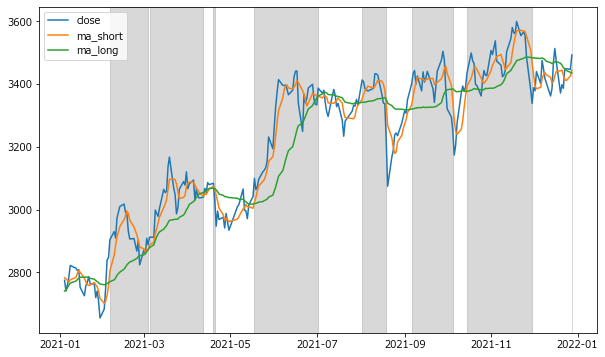

In [351]:
trade_log_dict_ts = {}
out_put_dict_ts = {}
for file in FILE:
    name_ = file[43:].replace('.csv','')
    total_pr = 0
    trade_log_list = []
    profit_rate = 0

    for year in [2017,2018,2019,2020,2021]:

        ts = TechnicalSimulation(hold_day=100)
        df_tmp = ts.make_df_con(file,path_daw)
        mean_ = df_tmp[df_tmp.index.year==year].mean()['close']
        # ddof = 0で普通の分散
        std_ = df_tmp[df_tmp.index.year==year].std()['close']
        mean_tpx = ex_tpx_dict[year][0]
        std_tpx = ex_tpx_dict[year][1]
        v1 = (mean_/std_)
        v2 = (mean_tpx/std_tpx)
        
        alpha = v1/v2
        
        
        ts.simulate(file,path_daw,start_year=year,end_year=year,is_validate=True)
        trade_log = ts.trade_log
        profit_rate = trade_log['profit rate'].values[0]
        total_pr+= alpha*profit_rate
        trade_log_list.append(profit_rate)
        
        # total_pr+= profit_rate
        # trade_log_list.append(profit_rate)
        
    print("------------------")
    print(name_)
    output = ''
    for tr in trade_log_list:
        output += ('{:.2f}'.format(tr)+' + ')
        # break
    output += ('{:.2f}'.format(np.std(trade_log_list))+' + ')
    output += ('{:.2f}'.format(total_pr)+' \\\\')
    print(output)
    trade_log_dict_ts[name_] = trade_log_list
    out_put_dict_ts[name_] = (np.std(trade_log_list),total_pr)

1. 三つのグループごとに, 年次収益率を合算
2. 合算した年次収益率で, 平均および, 標準偏差を求める

In [352]:
trade_log_dict_ts['GOMU']

[9.407999999999975,
 -18.66319999999998,
 -6.202800000000025,
 -7.178399999999983,
 33.54239999999998]

In [350]:
pr_sum_list = [0,0,0,0,0]
pr_sum_list

[0, 0, 0, 0, 0]

In [379]:
group1 = ['SENI','RIKUUN','KOUGYO','GINKOU','SYOKURYO','TEKKOU','KUUUN','DENKI_GASS','SUISAN_NOURINGYO','SEKIYU_SEKITAN','GOMU']
group2 = ['KENSETSU','SYOUKEN_SAKIMONO','HUDOUSAN','HIKINZOKU','PARUPU_KAMI','KINZOKU','IYAKUHIN','KAIUN','GARAS_DOSEKI','YUSOUYOUKIKI','SEIMITSUKIKI']
group3 = ['HOKEN','JOUHOU_TSUUSIN','SONOTAKINYUU','SONOTA_SEIHIN','SERVICE','SOUKO_UNYU','KOURI','DENKIKIKI','OROSIURI','KAGAKU','KIKAI']
pr_sum_list = [0,0,0,0,0]
count_ = 0
for i,name_ in enumerate(trade_log_dict):
    
    if name_ in group3:
        count_ += 1
        print(name_)
        trade_list_ = trade_log_dict[name_]
        
        for i in range(len(trade_list_)):
        
            pr_sum_list[i] += trade_list_[i]
        
print(count_)

DENKIKIKI
HOKEN
JOUHOU_TSUUSIN
KAGAKU
KIKAI
KOURI
OROSIURI
SERVICE
SONOTAKINYUU
SONOTA_SEIHIN
SOUKO_UNYU
11


In [380]:
pr_array = np.array(pr_sum_list)/11
round(np.mean(pr_array),2),round(np.std(pr_array),2)

(1.28, 2.21)

In [324]:
for i,key in enumerate(trade_gyosyu_dict):
    print("------------")
    print(key)

------------
DENKIKIKI
------------
DENKI_GASS
------------
GARAS_DOSEKI
------------
GINKOU
------------
GOMU
------------
HIKINZOKU
------------
HOKEN
------------
HUDOUSAN
------------
IYAKUHIN
------------
JOUHOU_TSUUSIN
------------
KAGAKU
------------
KAIUN
------------
KENSETSU
------------
KIKAI
------------
KINZOKU
------------
KOUGYO
------------
KOURI
------------
KUUUN
------------
OROSIURI
------------
PARUPU_KAMI
------------
RIKUUN
------------
SEIMITSUKIKI
------------
SEKIYU_SEKITAN
------------
SENI
------------
SERVICE
------------
SONOTAKINYUU
------------
SONOTA_SEIHIN
------------
SOUKO_UNYU
------------
SUISAN_NOURINGYO
------------
SYOKURYO
------------
SYOUKEN_SAKIMONO
------------
TEKKOU
------------
YUSOUYOUKIKI


# uds_gyosyu

In [373]:

trade_log_dict = {}
out_put_dict = {}
for file in FILE:
    name_ = file[43:].replace('.csv','')
    total_pr = 0
    trade_log_list = []
    profit_rate = 0

    for year in [2017,2018,2019,2020,2021]:

        ts = TechnicalSimulation(hold_day=100)
        df_tmp = ts.make_df_con(file,path_daw)
        mean_ = df_tmp[df_tmp.index.year==year].mean()['close']
        # ddof = 0で普通の分散
        std_ = df_tmp[df_tmp.index.year==year].std()['close']
        mean_tpx = ex_tpx_dict[year][0]
        std_tpx = ex_tpx_dict[year][1]
        v1 = (mean_/std_)
        v2 = (mean_tpx/std_tpx)       
        alpha = v1/v2
        
        # ts.simulate(file,path_daw,start_year=year,end_year=year,is_validate=True)
        trade_log = trade_gyosyu_dict[name_][str(year)][0]
        profit_rate = trade_log['profit rate'].values[0]
        total_pr+= alpha*profit_rate
        trade_log_list.append(profit_rate)
        
        # total_pr+= profit_rate
        # trade_log_list.append(profit_rate)
        
    print("------------------")
    print(name_)
    output = ''
    for tr in trade_log_list:
        output += ('{:.2f}'.format(tr)+' + ')
        # break
    output += ('{:.2f}'.format(np.std(trade_log_list))+' + ')
    output += ('{:.2f}'.format(total_pr)+' \\\\')
    
    print(output)
    trade_log_dict[name_] = trade_log_list
    out_put_dict[name_] = (np.std(trade_log_list),total_pr)

------------------
DENKIKIKI
-1.00 & 2.32 & 2.68 & 11.60 & -0.28 & 4.50 & 9.58 \\
------------------
DENKI_GASS
0.28 & 0.92 & 8.20 & 0.88 & -4.70 & 4.12 & 4.68 \\
------------------
GARAS_DOSEKI
4.12 & -4.08 & 4.36 & 3.24 & -6.92 & 4.71 & 0.77 \\
------------------
GINKOU
5.36 & -1.24 & 0.04 & 10.32 & 3.26 & 4.11 & 16.76 \\
------------------
GOMU
-4.04 & -2.00 & 11.52 & 11.16 & -1.88 & 6.89 & 18.90 \\
------------------
HIKINZOKU
3.84 & -4.12 & 4.88 & -3.80 & 3.50 & 3.96 & 4.03 \\
------------------
HOKEN
3.52 & -4.44 & 6.80 & 1.36 & -6.26 & 4.88 & 6.12 \\
------------------
HUDOUSAN
2.32 & -7.44 & 5.88 & 3.16 & -0.80 & 4.56 & 4.24 \\
------------------
IYAKUHIN
8.92 & -1.56 & 5.04 & 9.40 & 4.04 & 3.96 & 30.07 \\
------------------
JOUHOU_TSUUSIN
1.36 & -3.64 & -3.24 & 6.36 & -0.76 & 3.65 & -0.11 \\
------------------
KAGAKU
2.04 & 1.44 & 2.44 & 2.68 & 4.94 & 1.19 & 13.48 \\
------------------
KAIUN
4.12 & -9.48 & 3.56 & 4.32 & 7.84 & 5.97 & 5.41 \\
------------------
KENSETSU
3.00 & 

In [225]:
for i,key in enumerate(out_put_dict):
    proposed_tup = out_put_dict[key]
    ordinary_tup = out_put_dict_ts[key]
    # 0 : 標準偏差
    # 1 : 平均
    print(key)
    out_ = ''
    
    if proposed_tup[0]>=ordinary_tup[0]:
        print("std lose : \\textbf{"+"{:.2f}".format(ordinary_tup[0])+"}")
    
    if proposed_tup[1]<=ordinary_tup[1]:
        print("total lose : \\textbf{"+"{:.2f}".format(ordinary_tup[1])+"}")
    
    print("----------------------")

DENKIKIKI
total lose : \textbf{28.93}
----------------------
DENKI_GASS
std lose : \textbf{1.18}
----------------------
GARAS_DOSEKI
total lose : \textbf{14.27}
----------------------
GINKOU
std lose : \textbf{0.58}
----------------------
GOMU
----------------------
HIKINZOKU
----------------------
HOKEN
std lose : \textbf{4.07}
----------------------
HUDOUSAN
total lose : \textbf{10.94}
----------------------
IYAKUHIN
----------------------
JOUHOU_TSUUSIN
total lose : \textbf{9.66}
----------------------
KAGAKU
----------------------
KAIUN
----------------------
KENSETSU
----------------------
KIKAI
total lose : \textbf{6.26}
----------------------
KINZOKU
total lose : \textbf{10.70}
----------------------
KOUGYO
std lose : \textbf{1.03}
----------------------
KOURI
std lose : \textbf{3.66}
----------------------
KUUUN
std lose : \textbf{1.81}
total lose : \textbf{-0.73}
----------------------
OROSIURI
total lose : \textbf{10.25}
----------------------
PARUPU_KAMI
std lose : \textbf{3

# 業種別　棒グラフ

In [317]:
# Grup 1 平均精度
(0.38 + 0.45 + 0.35 + 0.38 + 0.44 + 0.38 + 0.37 + 0.35 + 0.33 + 0.43 + 0.37)/11

0.3845454545454546

In [318]:
# Group 2
(0.44 + 0.40 + 0.46 + 0.40 + 0.37 + 0.43 + 0.42 + 0.36 + 0.40 + 0.43 + 0.43)/11

0.4127272727272727

In [319]:
# Group 3
(0.39 + 0.42 + 0.41 + 0.35 + 0.47 + 0.48 + 0.43 + 0.44 + 0.46 + 0.44 + 0.40)/11

0.4263636363636364

<Figure size 432x288 with 0 Axes>

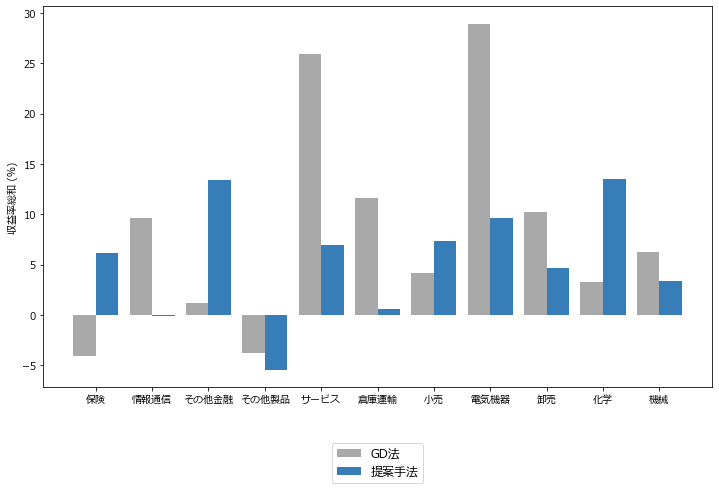

In [117]:
# pr_list = [17.87,-5.49,11.27,16.76,5.01,6.31,-0.77,4.68,1.80,7.90,18.90]
# pr_list_ts = [0.34,13.44,1.03,-0.15,3.25,-0.63,-0.73,-4.78,-0.49,-6.27,-6.66]

# pr_list = [9.06,3.89,4.24,4.03,14.81,6.99,30.07,5.41,0.77,14.07,2.54]
# pr_list_ts = [1.28,-3.32,10.94,3.77,-0.71,10.70,5.46,2.97,14.27,-9.50,28.69]

pr_list = [6.12,-0.11,13.39,-5.44,6.91,0.61,7.32,9.58,4.68,13.48,3.32]
pr_list_ts = [-4.12,9.66,1.20,-3.82,25.92,11.59,4.15,28.93,10.25,3.29,6.26]

height1 = pr_list_ts.copy()
height2 = pr_list.copy()


left = np.arange(len(height1))  # numpyで横軸を設定

# labels = ['繊維','陸運','鉱業','銀行業','食料品','鉄鋼','空運','電気ガス','農林水産業','石油石炭','ゴム']
# labels = ['建設','証券先物','不動産','非金属','パルプ紙','金属','医薬品','海運','ガラス土石','輸送用機器','精密機器']
labels = ['保険','情報通信','その他金融','その他製品','サービス','倉庫運輸','小売','電気機器','卸売','化学','機械']


width = 0.4
plt.clf()
fig, ax = plt.subplots(figsize=(12, 7), facecolor="w")
ax.bar(left, height1, color='darkgray', width=width, align='center',label='GD法')
ax.bar(left+width, height2, color='#377eb8', width=width, align='center',label='提案手法')

plt.xticks(left + width/2, labels)
# ax.set_xlabel(key)
ax.set_ylabel("収益率総和 (%)")
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='center',fontsize=12)
# ax.set_xticks(labels)

plt.show()

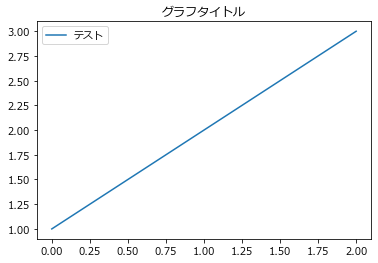

In [303]:
ax = plt.gca()
ax.plot([1,2,3],label='テスト')
ax.legend()
plt.title("グラフタイトル")
plt.show()

# ゴールデンクロスデッドクロス　凡例

   total_profit  profit rate  trade_count  max_profit  min_profit  \
1         -56.0        -2.24            6        56.0       -77.0   

   mean_profit  cant_buy_count  
1   -14.142857               0  



<Figure size 432x288 with 0 Axes>

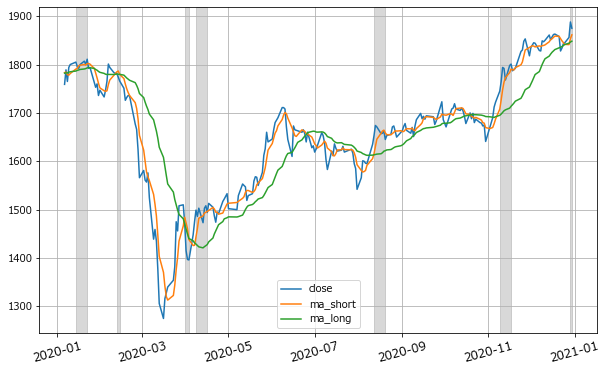

In [21]:
ts = TechnicalSimulation()
df_con = ts.make_df_con(path_tpx,path_daw)
ts.simulate(path_tpx,path_daw,start_year=2020,end_year=2020)

<Figure size 432x288 with 0 Axes>

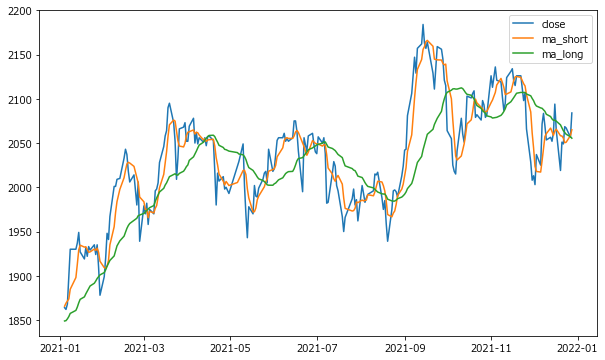

In [23]:
_,_,_,df_con,pl = ts.simulate_routine(path_tpx, path_daw,2021,2021,1,12)

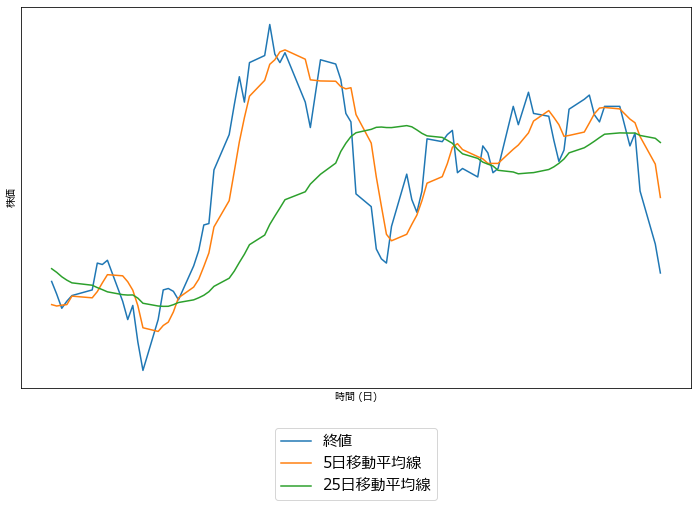

In [123]:
fig, ax = plt.subplots(figsize=(12, 7), facecolor="w")
ax.plot(df_['close'],label='終値')
ax.plot(df_['ma_short'],label='5日移動平均線')
ax.plot(df_['ma_long'],label='25日移動平均線')


# ax.set_xticks(range(0,20,2))
ax.axes.xaxis.set_ticks([])
ax.axes.yaxis.set_ticks([])
ax.set_xlabel("時間 (日)")
ax.set_ylabel("株価")
ax.legend(bbox_to_anchor=(0.5, -0.2), loc='center',fontsize=15)

ax.grid(True)
plt.show()


# 業種別　df 加工

In [199]:
def make_encoded_df():

    encoded_df = pd.DataFrame(
        columns={
            '出来高',
            '終値',
            '安値',
            '高値',
            '始値',
            '時刻',
            '日付',
            '市場',
            '銘柄名',
            # '銘柄コード',
            }
    )
    encoded_df = encoded_df.reindex(columns=[
        # '銘柄コード',
        '銘柄名',
        '市場',
        '日付',
        '時刻',
        '始値',
        '高値',
        '安値',
        '終値',
        '出来高'
    ])
    return encoded_df

In [243]:

def get_gyosyu_df2():
    path_gyosyu = '/Users/Owner/Desktop/StockPriceData/Gyosyu10/'
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace('/Users/Owner/Desktop/StockPriceData/Gyosyu10\\','')[:-4]
        encoded_df = make_encoded_df()
        
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'day',df.columns[1]:'close',df.columns[2]:'open',\
                                            df.columns[3]:'high',df.columns[4]:'low',df.columns[5]:'volume',\
                                            df.columns[6]:'pct_rate'})
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df.sort_index(inplace=True)
        encoded_df['始値'] = df['open'].map(lambda x: float(str(x).replace(',','')))
        encoded_df['高値'] = df['high'].map(lambda x: float(str(x).replace(',','')) )
        encoded_df['安値'] = df['low'].map(lambda x: float(str(x).replace(',','')))
        encoded_df['終値'] = df['close'].map(lambda x: float(str(x).replace(',','')) )
        encoded_df['日付'] = df.index
        
        df_dict[name] = encoded_df
    return df_dict,FILE


In [ ]:
df_dict,FILE = get_gyosyu_df2()

In [244]:
save_gyosyu_path =  '/Users/Owner/Desktop/StockPriceData/Gyosyu_encoded/'
for i,name in enumerate(df_dict):
    df_ = df_dict[name]
    df_.to_csv(save_gyosyu_path+'%s.csv' %name)

# 業種別　10年

In [245]:
def get_gyosyu_df():
    path_gyosyu = '/Users/Owner/Desktop/StockPriceData/Gyosyu_encoded/'
    FILE = glob.glob(path_gyosyu+'*.csv')
    df_dict = {}
    for file in FILE:
        name = file.replace('/Users/Owner/Desktop/StockPriceData/Gyosyu_encoded\\','')[:-4]
        df = pd.read_csv(file)
        df = df.rename(columns={df.columns[0]:'nan',df.columns[1]:'nan',df.columns[2]:'nan',\
                                    df.columns[3]:'day',df.columns[4]:'nan',df.columns[5]:'open',\
                                    df.columns[6]:'high',df.columns[7]:'low',df.columns[8]:'close',\
                                        df.columns[9]:'volume',})
        df = df.drop('nan',axis=1)
        df = df.drop(df.index[0])
        df['day'] = pd.to_datetime(df['day'],format='%Y/%m/%d')
        df.set_index('day',inplace=True)
        df_dict[name] = df

    return df_dict,FILE

In [246]:
df_dict,FILE = get_gyosyu_df()

In [260]:
uds_gyosyu_dict = {}
trade_gyosyu_dict = {}
for file in FILE:
    name_ = file[43:].replace('.csv','')
    # if name_=='KOUGYO' or name_=='SENI' or name_=='SYOKURYO' or name_=='RIKUUN' or name_=='GINKOU': 
    print(name_)
    v_dic, lx_dic = make_value_lx_dict(path_=file)
    uds_dict_, trade_dict_= return_uds_dict(v_dic,lx_dic,width=20,stride=5,\
        cut_off=6,order=4,path_=file,limit_year=2012)
    uds_gyosyu_dict[name_] = uds_dict_
    trade_gyosyu_dict[name_] = trade_dict_

encoded\DENKIKIKI


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
index 0 is out of bounds for axis 0 with size 0
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


C:\Users\Owner\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\xgboost\sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero
division by zero


In [ ]:
save_pickle_path = '/Users/Owner/Desktop/program/Sotsuron/code/pickles'
save_pickle(save_pickle_path+'/uds_gyosyu_dict_10.pickle',uds_gyosyu_dict)
save_pickle(save_pickle_path+'/trade_gyosyu_dict_10.pickle',trade_gyosyu_dict)